Module 5, Lab 4 - Factorial Designs
===================================

In this lab, we will explore the factorial experiment. I analyze the
data from the previous lab but using a factorial design. I assume you
are familiar with the between subjects lab, conducted previously. In
this lab, we consider whether the three logos have different effects for
males or females, a question which marketing wants to know prior to
pushing the ad to different markets.

Before we begin, I will load the packages required to run this notebook:

In [40]:
## LOAD PACKAGES 
import pandas as pd
import numpy as np
import scipy.stats as ss
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

Next, the dataset is loaded and the sentiment is computed:

In [26]:
## Load the dataset
dat = pd.read_csv("datasets/logos.csv")

## Compute sentiment and look at the head of the data frame.
dat['sentiment'] = dat[['friendly', 'inviting', 'interesting', 'positive', 'pleasant']].apply(np.mean, axis = 1)
dat.head()

,id,friendly,inviting,interesting,positive,pleasant,sex,logo,sentiment
0,3,9,8,9,10,9,f,Logo A,9.0
1,98,7,6,8,7,7,f,Logo C,7.0
2,73,5,3,6,6,6,m,Logo C,5.2
3,89,4,5,2,3,4,f,Logo C,3.6
4,13,8,7,9,8,6,f,Logo A,7.6


Finally, we need the specialized Python pyDOE package for designed experiments, which must be installed and imported:

In [27]:
!pip install --upgrade patsy
from patsy import EvalEnvironment, ModelDesc

Requirement already up-to-date: patsy in c:\users\stevepc2\anaconda3\lib\site-packages (0.5.0)
Requirement not upgraded as not directly required: six in c:\users\stevepc2\anaconda3\lib\site-packages (from patsy) (1.11.0)
Requirement not upgraded as not directly required: numpy>=1.4 in c:\users\stevepc2\anaconda3\lib\site-packages (from patsy) (1.14.5)


Vizualize the Data + Run Descriptives
=====================================

In a factorial design, we randomly assign a second treatment in addition
to the first. For example, we could also make 50% of the logos in color
and 50% in grey scale. Thus we would randomly assign people to one of
the designs (3 levels: A, B, and C) and one of the colors (2 levels:
color, grey scale). For this reason, this is referred to as a 2 x 3
factorial design.

One need not randomly assign the variable. One can also use a
pre-existing grouping variable, such as sex. One caveat is needed,
however; if the grouping variable was not randomly assigned to
participants (e.g., favorite color), we cannot be sure if any observed
effect is due to that variable or something else that might be causing
it. For example, if participants who love the color purple tend to
prefer Logo B, we don't know if that logo preference is due to the color
or something else that might cause that color preference (see the
discussion on prior causes in the regression lab).

In our case, we will examine a 2 (sex: male, female) x 3 (logo: A, B, C)
design. Although it is true that sex was not randomly assigned by the
research team to participants, biological sex is randomly assigned at
birth and has no known prior causes. Thus, any differences we see
between the sexes can be ultimately assumed to result from sex.

We can easily visualize our data using the seaborn package. You already performed visualization of sentiment by logo in a previous lab. Now, you can create a visualization by sex. 

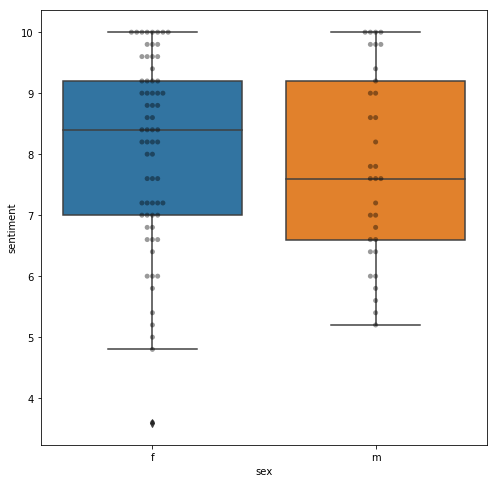

In [34]:
ax = plt.figure(figsize=(8,8)).gca() # define axis
sns.boxplot(x = 'sex', y = 'sentiment', data = dat, ax = ax)
sns.swarmplot(x = 'sex', y = 'sentiment', color = 'black', data = dat, ax = ax, alpha = 0.4)

There is not a great deal of difference in sentiment by sex. 

Now, you will visualize the interaction between sentiment and logo and sex. In this case we use the `hue` arguments to differentiate between male and female:

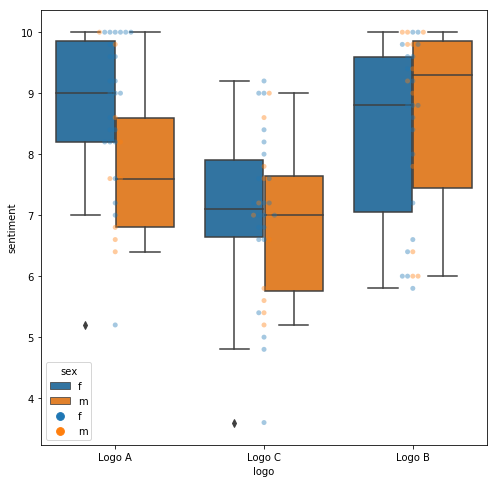

In [28]:
ax = plt.figure(figsize=(8,8)).gca() # define axis
sns.boxplot(x = 'logo', y = 'sentiment', data = dat, hue = 'sex', ax = ax)
sns.swarmplot(x = 'logo', y = 'sentiment', hue = 'sex', data = dat, ax = ax, alpha = 0.4)

We do not see any large systematic differences in the overall levels of
sentiment for males or females, nor do we see a substantively different
pattern of liking across the three logos for males or females. Thus,
perhaps sex does not matter much. 

Recall for `tapply()` accepts four arguments: the first is the variable
to analyze, the second is a factor (or list of factors) across which we
want to run the analysis, the third is the function we want to use in
the analysis, and the rest are arguments to pass along to our function.
In this case, we want means of `sentiment` across levels of `logo` and
`sex`, with missing values ignored:

In [18]:
dat_grouped = dat[['sentiment','logo','sex']].groupby(['logo','sex'])
print('The means of the groups:')
print(dat_grouped.mean())
print('\n')
print('The standard deviations of the groups:')
print(dat_grouped.std())

The means of the groups:
            sentiment
logo   sex           
Logo A f     8.808333
       m     7.955556
Logo B f     8.340000
       m     8.616667
Logo C f     7.054545
       m     6.900000


The standard deviations of the groups:
            sentiment
logo   sex           
Logo A f     1.197794
       m     1.318248
Logo B f     1.471269
       m     1.621354
Logo C f     1.403644
       m     1.237299


Next, we can conduct the factorial ANOVA. In general, the ANOVA assesses
whether:

1.  There are significant differences between the two sexes (similar to
    a one-way ANOVA or t-test)
2.  There are significant differences between the three logos (similar
    to a one-way ANOVA or t-test)
3.  The two variables interact

I consider these three questions next.

Example with the `ez` package:
==============================

Factorial ANOVA designs can get tricky. The best way to conduct the
analysis for real-world data is to use the `ezANOVA()` command from the
`ez` package. This is because you can control the "type" of the analysis
done. This goes beyond the scope of this tutorial, but most experimental
researchers prefer to us "type 3" analyses for ANOVA. Note that the
`aov()` command we used in the previous lab only works for perfectly
balanced factorial designs (equal numbers of people in every permutation
of the experiment, no missing data).

To use this command, you run the `ezANOVA()` command. We must specify
several arguments, including the standard `data=` argument, the `type=3`
argument, and a few others.

Second, we must list our variables. This is done by setting them inside
`.()`. First, we have a variable called `wid=.()` that tracks the ID of
each participant. If you don't have an id variable, we can easily give
each participant a unique identifier with `1:nrow(dat)`, which creates a
unique number for each participant. Next, we list the outcome variable
as `dv`, in this case `dv=.(sentiment)`. Finally, we list our
between-subjects variables using `between=.(sex, logo)`.

In [38]:
A_m = dat.loc[(dat.logo == 'Logo A') & (dat.sex == 'm'), 'sentiment']
A_f = dat.loc[(dat.logo == 'Logo A') & (dat.sex == 'f'), 'sentiment']
B_m = dat.loc[(dat.logo == 'Logo B') & (dat.sex == 'm'), 'sentiment']
B_f = dat.loc[(dat.logo == 'Logo B') & (dat.sex == 'f'), 'sentiment']
C_m = dat.loc[(dat.logo == 'Logo C') & (dat.sex == 'm'), 'sentiment']
C_f = dat.loc[(dat.logo == 'Logo C') & (dat.sex == 'f'), 'sentiment']

f_statistic, p_value = ss.f_oneway(A_m, A_f, B_m,  B_f, C_m, C_f)
print('F-Satatistic = ' + str(f_statistic))
print('p_value = ' + str(p_value))

F-Satatistic = 6.026612690740005
p_value = 7.102744092104675e-05


In [60]:
dat.head()

,id,friendly,inviting,interesting,positive,pleasant,sex,logo,sentiment
0,3,9,8,9,10,9,f,Logo A,9.0
1,98,7,6,8,7,7,f,Logo C,7.0
2,73,5,3,6,6,6,m,Logo C,5.2
3,89,4,5,2,3,4,f,Logo C,3.6
4,13,8,7,9,8,6,f,Logo A,7.6


In [68]:
dat['logo_sex'] = dat.logo + '_' + dat.sex
print(dat.head(10))

#
Tukey_HSD = pairwise_tukeyhsd(dat.sentiment, dat.logo)
#print(Tukey_HSD)
#Tukey_HSD.plot_simultaneous()

   id  friendly  inviting  interesting  positive  pleasant sex    logo  \
0   3         9         8            9        10         9   f  Logo A   
1  98         7         6            8         7         7   f  Logo C   
2  73         5         3            6         6         6   m  Logo C   
3  89         4         5            2         3         4   f  Logo C   
4  13         8         7            9         8         6   f  Logo A   
5  19         8         7            7         9         7   m  Logo A   
6  42         9         8           10         8         8   f  Logo B   
7  21         9         9            9         9         9   f  Logo A   
8  86         5         5            4         6         5   f  Logo C   
9  38        10         9           10        10        10   f  Logo B   

   sentiment  logo_sex  
0        9.0  Logo A_f  
1        7.0  Logo C_f  
2        5.2  Logo C_m  
3        3.6  Logo C_f  
4        7.6  Logo A_f  
5        7.6  Logo A_m  
6        8

TypeError: '<' not supported between instances of 'float' and 'str'

In [12]:
#generate id variable for each subject
dat$idvar <- 1:nrow(dat)

ezANOVA(data=dat, 
        wid=.(idvar), 
        dv=.(sentiment), 
        between=.(sex, logo),
        type=3)

## Warning: Converting "idvar" to factor for ANOVA.

## Warning: You have removed one or more levels from variable "logo".
## Refactoring for ANOVA.

## Warning: Data is unbalanced (unequal N per group). Make sure you specified
## a well-considered value for the type argument to ezANOVA().

## $ANOVA
##     Effect DFn DFd          F            p p<.05         ges
## 2      sex   1  93  0.6831763 4.106107e-01       0.007292412
## 3     logo   2  93 11.2931682 4.067288e-05     * 0.195406629
## 4 sex:logo   2  93  1.1956369 3.071178e-01       0.025068057
## 
## $`Levene's Test for Homogeneity of Variance`
##   DFn DFd      SSn      SSd         F         p p<.05
## 1   5  93 1.283869 80.80522 0.2955249 0.9142809

Warning message:
"Converting "idvar" to factor for ANOVA."Warning message:
"You have removed one or more levels from variable "logo". Refactoring for ANOVA."Warning message:
"Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA()."Coefficient covariances computed by hccm()


$ANOVA
    Effect DFn DFd          F            p p<.05         ges
2      sex   1  93  0.6831763 4.106107e-01       0.007292412
3     logo   2  93 11.2931682 4.067288e-05     * 0.195406629
4 sex:logo   2  93  1.1956369 3.071178e-01       0.025068057

$`Levene's Test for Homogeneity of Variance`
  DFn DFd      SSn      SSd         F         p p<.05
1   5  93 1.283869 80.80522 0.2955249 0.9142809

This produces a lot of output, but generally speaking, it produces the
same results you would expect from the `aov()` output. There are three
rows, similar to a regression output. One row, for `sex` is not
significant. One row, for `logo` is significant. A third row, for
`sex:logo` is not significant.

This can be interpreted as follows:

1.  There is not a significant sex difference overall
2.  There are significant differences between the logos
3.  There is not a significant "interaction" between sex and logo.

Interactions can be understand as "one variable influences the effect of
another." So, the sex x logo interaction is asking: "is there a
different pattern of differences between the logos for males than for
females?" This is not the same as asking whether males or females have
different levels of sentiment. Instead, we are asking whether the effect
of `logo` is different at different levels of `sex`.

You can also reverse this. This is the same as asking whether the effect
of `sex` is different across the three `logos`. An interaction is
essentially one variable influencing the effectiveness of another.

It's worth remembering that a non-significant effect does *not* mean
that there is zero effect. We can easily see the 95% CIs for our
"non-significant" effects with Tukey's HSD test (below).

It turns out you cannot perform Tukey's HST test on an `ezANOVA()`
object; however, you can tell `ezANOVA()` to save an `aov` object for
use in Tukey's and other tests. To do this, include the
`return_aov=TRUE` argument. This will save in our output an `aov` object
that we can feed into Tukey's test and other post-hoc comparison tests.

In [13]:
mod <- ezANOVA(data=dat, 
        wid=.(idvar), 
        dv=.(sentiment), 
        between=.(sex, logo),
        type=3,
        return_aov=TRUE)

## Warning: Converting "idvar" to factor for ANOVA.

## Warning: You have removed one or more levels from variable "logo".
## Refactoring for ANOVA.

## Warning: Data is unbalanced (unequal N per group). Make sure you specified
## a well-considered value for the type argument to ezANOVA().

Warning message:
"Converting "idvar" to factor for ANOVA."Warning message:
"You have removed one or more levels from variable "logo". Refactoring for ANOVA."Warning message:
"Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA()."Coefficient covariances computed by hccm()


From here, we can access the `aov` object with `mod$aov`. This can be
thrown into Tukey's test:

In [14]:
mod$aov

## Call:
##    aov(formula = formula(aov_formula), data = data)
## 
## Terms:
##                       sex      logo  sex:logo Residuals
## Sum of Squares    1.60020  50.64975   4.50382 175.15977
## Deg. of Freedom         1         2         2        93
## 
## Residual standard error: 1.372384
## Estimated effects may be unbalanced
## 1 observation deleted due to missingness

TukeyHSD(mod$aov)

##   Tukey multiple comparisons of means
##     95% family-wise confidence level
## 
## Fit: aov(formula = formula(aov_formula), data = data)
## 
## $sex
##          diff        lwr       upr     p adj
## m-f -0.269697 -0.8507293 0.3113353 0.3590456
## 
## $logo
##                     diff        lwr        upr     p adj
## Logo B-Logo A -0.1044249 -0.9154011  0.7065513 0.9495008
## Logo C-Logo A -1.5541241 -2.3528990 -0.7553493 0.0000345
## Logo C-Logo B -1.4496992 -2.2547827 -0.6446157 0.0001290
## 
## $`sex:logo`
##                         diff       lwr         upr     p adj
## m:Logo A-f:Logo A -0.8527778 -2.413761  0.70820507 0.6073211
## f:Logo B-f:Logo A -0.4683333 -1.677465  0.74079878 0.8688982
## m:Logo B-f:Logo A -0.1916667 -1.603629  1.22029545 0.9987202
## f:Logo C-f:Logo A -1.7537879 -2.932560 -0.57501539 0.0005264
## m:Logo C-f:Logo A -1.9083333 -3.320295 -0.49637122 0.0021770
## f:Logo B-m:Logo A  0.3844444 -1.218545  1.98743433 0.9817530
## m:Logo B-m:Logo A  0.6611111 -1.099915  2.42213727 0.8832351
## f:Logo C-m:Logo A -0.9010101 -2.481225  0.67920529 0.5619348
## m:Logo C-m:Logo A -1.0555556 -2.816582  0.70547060 0.5065658
## m:Logo B-f:Logo B  0.2766667 -1.181602  1.73493487 0.9937332
## f:Logo C-f:Logo B -1.2854545 -2.519316 -0.05159324 0.0360762
## m:Logo C-f:Logo B -1.4400000 -2.898268  0.01826820 0.0549848
## f:Logo C-m:Logo B -1.5621212 -2.995317 -0.12892540 0.0243601
## m:Logo C-m:Logo B -1.7166667 -3.347060 -0.08627326 0.0330050
## m:Logo C-f:Logo C -0.1545455 -1.587741  1.27865036 0.9995814

Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                      sex      logo  sex:logo Residuals
Sum of Squares    1.60020  50.64975   4.50382 175.15977
Deg. of Freedom         1         2         2        93

Residual standard error: 1.372384
Estimated effects may be unbalanced
1 observation deleted due to missingness

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = formula(aov_formula), data = data)

$sex
         diff        lwr       upr     p adj
m-f -0.269697 -0.8507293 0.3113353 0.3590456

$logo
                    diff        lwr        upr     p adj
Logo B-Logo A -0.1044249 -0.9154011  0.7065513 0.9495008
Logo C-Logo A -1.5541241 -2.3528990 -0.7553493 0.0000345
Logo C-Logo B -1.4496992 -2.2547827 -0.6446157 0.0001290

$`sex:logo`
                        diff       lwr         upr     p adj
m:Logo A-f:Logo A -0.8527778 -2.413761  0.70820507 0.6073211
f:Logo B-f:Logo A -0.4683333 -1.677465  0.74079878 0.8688982
m:Logo B-f:Logo A -0.1916667 -1.603629  1.22029545 0.9987202
f:Logo C-f:Logo A -1.7537879 -2.932560 -0.57501539 0.0005264
m:Logo C-f:Logo A -1.9083333 -3.320295 -0.49637122 0.0021770
f:Logo B-m:Logo A  0.3844444 -1.218545  1.98743433 0.9817530
m:Logo B-m:Logo A  0.6611111 -1.099915  2.42213727 0.8832351
f:Logo C-m:Logo A -0.9010101 -2.481225

We see here that Tukey's test is returning more output than before, but
we will only look at the overall logo analysis, given that nothing else
was significant. We can also glance at the other analyses, specifically
the confidence intervals (`lwr` and `upr` = the 95% CI). We see on many
analyses that the confidence intervals are fairly large, especially
toward the bottom third of the results where every individual
permutation is compared against every other permutation. This tells us
we may simply lack statistical power to find some effects. Power for
ANOVA designs goes beyond the scope of this tutorial, but it's safe to
say that large samples are desired.

What if the interaction *had* been significant? That would simply tell
us that at least one comparison (e.g., Logo A vs Logo B) yielded
significantly different results across sexes (Male vs. Female). It could
have been every logo comparison, two, or just one. To help isolate which
parts of the logo pattern differ across males and females, we will use a
tool called "interaction contrasts." Simply put, this technique isolates
which comparisons differ across sexes, allowing the researcher to
isolate where the interaction is happening.

To do this, we use the `phia` package (post-hoc interaction analysis).

Next, we can use the `testInteractions()` command. We see here that it
returns a list of three rows:

In [15]:
library(phia)

## Loading required package: car

## 
## Attaching package: 'car'

## The following object is masked from 'package:psych':
## 
##     logit

testInteractions(mod$aov)

## F Test: 
## P-value adjustment method: holm
##                        Value Df Sum of Sq      F Pr(>F)
## f-m : Logo A-Logo B  1.12944  1     4.459 2.3672 0.3819
## f-m : Logo A-Logo C  0.69823  1     1.731 0.9193 0.6803
## f-m : Logo B-Logo C -0.43121  1     0.709 0.3766 0.6803
## Residuals                    93   175.160

Warning message:
"package 'phia' was built under R version 3.5.1"Loading required package: car
Warning message:
"package 'car' was built under R version 3.5.1"Loading required package: carData

Attaching package: 'car'

The following object is masked from 'package:psych':

    logit



,Value,Df,Sum of Sq,F,Pr(>F)
f-m : Logo A-Logo B,1.1294444,1,4.4585642,2.3672472,0.3819029
f-m : Logo A-Logo C,0.6982323,1,1.7314909,0.9193244,0.6802770
f-m : Logo B-Logo C,-0.4312121,1,0.7093813,0.3766416,0.6802770
Residuals,NA,93,175.1597677,NA,NA


The first row is listed `f-m : Logo A-Logo B`, which means we ask
whether the "Logo A vs. B" comparison is *different* for males and
females. We see that it is not significant (*p* = .38). None of these is
significant, which does not surprise as the interaction was not
significant to begin with. Truthfully, this just dissects the
interaction. If the interaction was not significant to begin with,
dissecting it is generally not seen as statistically responsible.